# Song genre prediction
<b>Predict a song genre using its track information and features</b>

For this project, my research question is: <b>Can we predict a track genre based on track info and features?</b><br>
<br>
Through its API, Spotify provided users with variety of track features, from tempo and key to whether the song is with lyrics or not and whether the song is suitable for dancing or not. These track features will be the X variables. Using these track features, I will predict the genre of the song. This also means, that genre is the Y variable.<br>
<br>
The unit of observation of this project is song. I will use 6 Spotify playlists from 6 different era: All Out 50s, All Out 60s, All Out 70s, All Out 80s, All Out 90s, and All Out 00s. Each playlist consist of minimum 100 songs.<br>
<br>
For this proejctI will use <a href="https://github.com/plamere/spotipy">Spotipy</a> library to get data from Spotify API. Let's get started!

## Data processing

In this section, I will firstly get the track IDs from all the playlist. Then, I from each track ID, will get the track features. From the Artist data, I will then get the possible genre of the song. Why possible genre? Because in Spotify, the genre is related to the artist, not the song. Therefore, each song might be tagged with multiple genre. These list of genre that is a categorical variables then will be transformed into dummy variables.
<hr>

Import necessary libraries for getting data from Spotify API and create files, then connect with my Spotify for Developer credentials

In [1]:
from __future__ import print_function
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from pprint import pprint
import json
import csv
import time
import sys
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt


sp = spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials(client_id='eaa563769e874ccd85c8185f682ef625', client_secret='9d60c77a99e34791a1b126a06d43dcf6'))

Next, define the playlist IDs I'm going to work with. Since I hand-picked the playlist through Spotify Web Player, I was able to get the playlist ID through Spotify Web Player. Another way of doing this is to get a list of a user's playlist and search for the playlist IDs.<br>
<br>
In the below array, the playlist are sorted by oldest to newest (50s to 00s)

In [2]:
playlists = ['37i9dQZF1DWSV3Tk4GO2fq', '37i9dQZF1DXaKIA8E7WcJj', '37i9dQZF1DWTJ7xPn4vNaz', '37i9dQZF1DX4UtSsGT1Sbe', '37i9dQZF1DXbTxeAdrVG2l', '37i9dQZF1DX4o1oenSJRJd']

In the below code, we're getting the track IDs of every song on the above playlists and save them in a csv file, so that we can work with the data locally in the next process.

In [3]:
#source this
get_tracks = []

for list in playlists:
    offset = 0    
    
    while True:
        response = sp.playlist_items(list,
                                     offset=offset,
                                     fields='items.track.id,total',
                                     additional_types=['track'])

        if len(response['items']) == 0:
            break
        
        get_tracks.extend(response['items'])
        offset = offset + len(response['items'])
        

with open("tracks.json", "w") as outfile:
    json.dump(get_tracks, outfile)

In the below code, we take the tracks data stored locally and continue work with it. The data was saved as json file, we're going to transform it into a dataframe (df) for further working on it.

In [4]:
import pandas as pd

data = pd.read_json("tracks.json")
df = pd.json_normalize(data['track'])
df.head()

,id
0,06PdA0DLgF4BfAeUNZAbFG
1,3KzgdYUlqV6TOG7JCmx2Wg
2,40KCF1U2DNceYsugxZQruU
3,72nqbbrKjhXmDdRXQGq115
4,5ueyLj6e6oVaTY0KQ6yLaA


In the next step, we take the track names, artist names and artist ids from the track id data we have.

In [5]:
#source this
tracks = df['id']
track_names = []
track_artists_name = []
track_artists_id = []

for track in tracks:
    urn = 'spotify:track:' + track
    track = sp.track(urn)
    track_name = track['name']
    track_artist_name = track['artists'][0]['name']
    track_artist_id = track['artists'][0]['id']
    track_explicit = track['explicit']
    track_album_type = track['album']['album_type']
    track_names.append(track_name)
    track_artists_name.append(track_artist_name)
    track_artists_id.append(track_artist_id)
    
df['track names'] = track_names
df['artists name'] = track_artists_name
df['artists id'] = track_artists_id

df.head()

,id,track names,artists name,artists id
0,06PdA0DLgF4BfAeUNZAbFG,Blueberry Hill,Fats Domino,09C0xjtosNAIXP36wTnWxd
1,3KzgdYUlqV6TOG7JCmx2Wg,Beyond the Sea,Bobby Darin,0EodhzA6yW1bIdD5B4tcmJ
2,40KCF1U2DNceYsugxZQruU,Broken Hearted Melody,Sarah Vaughan,1bgyxtWjZwA5PQlDsvs9b8
3,72nqbbrKjhXmDdRXQGq115,All I Have to Do Is Dream,The Everly Brothers,4ACplpEqD6JIVgKrafauzs
4,5ueyLj6e6oVaTY0KQ6yLaA,All Shook Up,Elvis Presley,43ZHCT0cAZBISjO8DG9PnE


Source: https://developer.spotify.com/documentation/web-api/reference/object-model/#audio-features-object<br>
<br>
Next:<br>
From each track ID, will get the track features consisting of the following:
<ul>
    <li><b>Accousticness</b> (A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.)</li>
    <li><b>Danceability</b> (Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.)</li>
    <li><b>Duration_ms</b> (The duration of the track in milliseconds.)</li>
    <li><b>Energy</b> (Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.)</li>
    <li><b>Instrumentalness</b> (Predicts whether a track contains no vocals. “Ooh” and “aah” sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly “vocal”. The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.)</li>
    <li><b>Key</b> (The key the track is in. Integers map to pitches using standard Pitch Class notation. E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on.)</li>
    <li><b>Liveness</b> (Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.)</li>
    <li><b>Loudness</b> (The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typical range between -60 and 0 db.)</li>
    <li><b>Mode</b> (Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.)</li>
    <li><b>Speechiness</b> (Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.)</li>
    <li><b>Time signature</b> (An estimated overall time signature of a track. The time signature (meter) is a notational convention to specify how many beats are in each bar (or measure).)</li>
    <li><b>Valence</b> (A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).)</li>
    <li><b>Album types</b> (The type of the album of the track: album, single, or compilation.)
</ul>

In [6]:
#source this
track_ids = df['id']
track_acousticness = []
track_danceability = []
track_duration_ms = []
track_energy = []
track_instrumentalness = []
track_key = []
track_liveness = []
track_loudness = []
track_mode = []
track_speechiness = []
track_time_signature = []
track_valence = []
                                            
for id in track_ids:
    features = sp.audio_features(id)
    acousticness = features[0]['acousticness']
    danceability = features[0]['danceability']
    duration_ms = features[0]['duration_ms']
    energy = features[0]['energy']
    instrumentalness = features[0]['instrumentalness']
    key = features[0]['key']
    liveness = features[0]['liveness']
    loudness = features[0]['loudness']
    mode = features[0]['mode']
    speechiness = features[0]['speechiness']
    time_signature = features[0]['time_signature']
    valence = features[0]['valence']
    
    track_acousticness.append(acousticness)
    track_danceability.append(danceability)
    track_duration_ms.append(duration_ms)
    track_energy.append(energy)
    track_instrumentalness.append(instrumentalness)
    track_key.append(key)
    track_liveness.append(liveness)
    track_loudness.append(loudness)
    track_mode.append(mode)
    track_speechiness.append(speechiness)
    track_time_signature.append(time_signature)
    track_valence.append(valence)
    
df['track acousticness'] = track_acousticness
df['track danceability'] = track_danceability
df['track duration_ms'] = track_duration_ms
df['track energy'] = track_energy
df['track instrumentalness'] = track_instrumentalness
df['track key'] = track_key
df['track liveness'] = track_liveness
df['track loudness'] = track_loudness
df['track mode'] = track_mode
df['track speechiness'] = track_speechiness
df['track time_signature'] = track_time_signature
df['track valence'] = track_valence

df.head()

,id,track names,artists name,artists id,track acousticness,track danceability,track duration_ms,track energy,track instrumentalness,track key,track liveness,track loudness,track mode,track speechiness,track time_signature,track valence
0,06PdA0DLgF4BfAeUNZAbFG,Blueberry Hill,Fats Domino,09C0xjtosNAIXP36wTnWxd,0.740,0.489,147880,0.499,0.000236,11,0.156,-9.702,1,0.0271,3,0.829
1,3KzgdYUlqV6TOG7JCmx2Wg,Beyond the Sea,Bobby Darin,0EodhzA6yW1bIdD5B4tcmJ,0.723,0.521,172480,0.516,0.000000,2,0.257,-7.456,0,0.0369,4,0.569
2,40KCF1U2DNceYsugxZQruU,Broken Hearted Melody,Sarah Vaughan,1bgyxtWjZwA5PQlDsvs9b8,0.744,0.448,143267,0.500,0.000000,7,0.191,-11.304,1,0.0356,4,0.768
3,72nqbbrKjhXmDdRXQGq115,All I Have to Do Is Dream,The Everly Brothers,4ACplpEqD6JIVgKrafauzs,0.783,0.542,141240,0.347,0.000000,4,0.144,-14.011,1,0.0268,4,0.596
4,5ueyLj6e6oVaTY0KQ6yLaA,All Shook Up,Elvis Presley,43ZHCT0cAZBISjO8DG9PnE,0.881,0.624,117080,0.468,0.000006,10,0.144,-12.162,1,0.1320,4,0.952


In the last step of gathering the data for this project, we'll get the genres from artist ids. The result might return a few genres per artist, therefore for this project, we use only the last genre with the assumption that it's the broadest genre. From then on, we filter it one more time to show only rock genre.

In [7]:
#source this
artists_id = df['artists id']
genres = []

for artist in artists_id:
    urn = 'spotify:artist:' + artist
    artist = sp.artist(urn)
    artist_genres = artist['genres']
    
    if len(artist_genres) != 0:
        broad_genre = artist_genres[-1] #only the last genre with the assumption that it's the broadest genre, also otherwise too many genre present.
    else:
        broad_genre = 'no genre'
    
    genres.append(broad_genre)
    
df['genres'] = genres
df.to_csv('raw_data.csv', index=False)

In [8]:
df1 = pd.read_csv('raw_data.csv')  
df2 = df1[df1['genres'].str.contains('pop|rock')]
df2['genres'].value_counts()

soft rock              154
rockabilly              56
rock                    50
pop rock                40
yacht rock              40
pop                     28
post-teen pop           25
rock-and-roll           21
sunshine pop            18
europop                 12
swedish pop             12
synthpop                11
symphonic rock          10
pop rap                  8
dance pop                8
viral pop                5
sophisti-pop             5
swamp rock               4
scottish rock            4
pop dance                4
new wave pop             4
roots rock               2
country rock             2
folk rock                1
britpop                  1
classic garage rock      1
glam rock                1
nz pop                   1
power pop                1
classic uk pop           1
australian rock          1
latin pop                1
swamp pop                1
Name: genres, dtype: int64

In [9]:
df2.loc[df2['genres'].str.contains('pop'), 'genres-transformed'] = 'pop'
df2.loc[df2['genres'].str.contains('rock'), 'genres-transformed'] = 'rock'
df2.head()

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


,id,track names,artists name,artists id,track acousticness,track danceability,track duration_ms,track energy,track instrumentalness,track key,track liveness,track loudness,track mode,track speechiness,track time_signature,track valence,genres,genres-transformed
3,72nqbbrKjhXmDdRXQGq115,All I Have to Do Is Dream,The Everly Brothers,4ACplpEqD6JIVgKrafauzs,0.783,0.542,141240,0.347,0.000000,4,0.1440,-14.011,1,0.0268,4,0.596,sunshine pop,pop
4,5ueyLj6e6oVaTY0KQ6yLaA,All Shook Up,Elvis Presley,43ZHCT0cAZBISjO8DG9PnE,0.881,0.624,117080,0.468,0.000006,10,0.1440,-12.162,1,0.1320,4,0.952,rockabilly,rock
5,50RwvvEKX5Q7AZt8FTAwIF,That'll Be The Day,Buddy Holly,3wYyutjgII8LJVVOLrGI0D,0.467,0.536,150133,0.637,0.000000,2,0.0838,-7.774,1,0.0343,4,0.798,rockabilly,rock
8,2FkCjtQ1lYsf71s2FAS8hE,The Great Pretender,The Platters,6KWcxMWVNVIYbdOQyJtsSy,0.943,0.425,160667,0.401,0.000003,7,0.0720,-9.427,1,0.0315,3,0.531,rockabilly,rock
9,4MUGG9mgDUP8dlaS3AAeg0,Stagger Lee,Lloyd Price,3iOE5ItEv5xr9fmKi7GNh2,0.675,0.396,144960,0.618,0.000000,3,0.0982,-8.209,1,0.0311,4,0.824,rockabilly,rock


In [10]:
dummies = df2['genres-transformed'].str.get_dummies()
df2 = pd.concat([df2, dummies], axis=1) 
df2.head()

,id,track names,artists name,artists id,track acousticness,track danceability,track duration_ms,track energy,track instrumentalness,track key,track liveness,track loudness,track mode,track speechiness,track time_signature,track valence,genres,genres-transformed,pop,rock
3,72nqbbrKjhXmDdRXQGq115,All I Have to Do Is Dream,The Everly Brothers,4ACplpEqD6JIVgKrafauzs,0.783,0.542,141240,0.347,0.000000,4,0.1440,-14.011,1,0.0268,4,0.596,sunshine pop,pop,1,0
4,5ueyLj6e6oVaTY0KQ6yLaA,All Shook Up,Elvis Presley,43ZHCT0cAZBISjO8DG9PnE,0.881,0.624,117080,0.468,0.000006,10,0.1440,-12.162,1,0.1320,4,0.952,rockabilly,rock,0,1
5,50RwvvEKX5Q7AZt8FTAwIF,That'll Be The Day,Buddy Holly,3wYyutjgII8LJVVOLrGI0D,0.467,0.536,150133,0.637,0.000000,2,0.0838,-7.774,1,0.0343,4,0.798,rockabilly,rock,0,1
8,2FkCjtQ1lYsf71s2FAS8hE,The Great Pretender,The Platters,6KWcxMWVNVIYbdOQyJtsSy,0.943,0.425,160667,0.401,0.000003,7,0.0720,-9.427,1,0.0315,3,0.531,rockabilly,rock,0,1
9,4MUGG9mgDUP8dlaS3AAeg0,Stagger Lee,Lloyd Price,3iOE5ItEv5xr9fmKi7GNh2,0.675,0.396,144960,0.618,0.000000,3,0.0982,-8.209,1,0.0311,4,0.824,rockabilly,rock,0,1


In [11]:
corr = df2.corr()
corr

,track acousticness,track danceability,track duration_ms,track energy,track instrumentalness,track key,track liveness,track loudness,track mode,track speechiness,track time_signature,track valence,pop,rock
track acousticness,1.000000,-0.331582,-0.311224,-0.554659,0.037637,0.042611,0.022591,-0.376041,0.164208,-0.046427,-0.191581,-0.207785,-0.225092,0.225092
track danceability,-0.331582,1.000000,0.018774,0.295653,-0.029215,-0.052280,-0.090444,0.220928,-0.166974,0.136281,0.148098,0.485495,0.214303,-0.214303
track duration_ms,-0.311224,0.018774,1.000000,0.053799,0.015783,-0.044440,-0.060588,0.005458,-0.014583,-0.160470,-0.016546,-0.266660,0.007395,-0.007395
track energy,-0.554659,0.295653,0.053799,1.000000,-0.049831,-0.077708,0.179099,0.761036,-0.101313,0.234496,0.212808,0.451249,0.242062,-0.242062
track instrumentalness,0.037637,-0.029215,0.015783,-0.049831,1.000000,0.102860,0.062724,-0.127387,-0.075466,-0.014302,0.034290,-0.024014,-0.052181,0.052181
track key,0.042611,-0.052280,-0.044440,-0.077708,0.102860,1.000000,-0.044565,-0.083534,-0.124367,0.078822,-0.008342,-0.095288,0.018536,-0.018536
track liveness,0.022591,-0.090444,-0.060588,0.179099,0.062724,-0.044565,1.000000,0.158156,0.006324,0.072189,-0.037163,0.070183,0.083566,-0.083566
track loudness,-0.376041,0.220928,0.005458,0.761036,-0.127387,-0.083534,0.158156,1.000000,-0.097470,0.200696,0.118516,0.164720,0.310112,-0.310112
track mode,0.164208,-0.166974,-0.014583,-0.101313,-0.075466,-0.124367,0.006324,-0.097470,1.000000,-0.108792,-0.051308,-0.108504,-0.157412,0.157412
track speechiness,-0.046427,0.136281,-0.160470,0.234496,-0.014302,0.078822,0.072189,0.200696,-0.108792,1.000000,0.067726,0.187982,0.120742,-0.120742


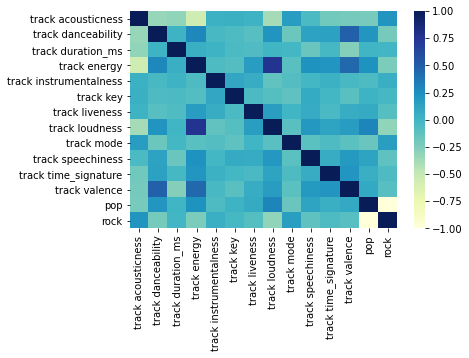

In [12]:
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap="YlGnBu")
plt.show()

In [13]:
df2.head()

,id,track names,artists name,artists id,track acousticness,track danceability,track duration_ms,track energy,track instrumentalness,track key,track liveness,track loudness,track mode,track speechiness,track time_signature,track valence,genres,genres-transformed,pop,rock
3,72nqbbrKjhXmDdRXQGq115,All I Have to Do Is Dream,The Everly Brothers,4ACplpEqD6JIVgKrafauzs,0.783,0.542,141240,0.347,0.000000,4,0.1440,-14.011,1,0.0268,4,0.596,sunshine pop,pop,1,0
4,5ueyLj6e6oVaTY0KQ6yLaA,All Shook Up,Elvis Presley,43ZHCT0cAZBISjO8DG9PnE,0.881,0.624,117080,0.468,0.000006,10,0.1440,-12.162,1,0.1320,4,0.952,rockabilly,rock,0,1
5,50RwvvEKX5Q7AZt8FTAwIF,That'll Be The Day,Buddy Holly,3wYyutjgII8LJVVOLrGI0D,0.467,0.536,150133,0.637,0.000000,2,0.0838,-7.774,1,0.0343,4,0.798,rockabilly,rock,0,1
8,2FkCjtQ1lYsf71s2FAS8hE,The Great Pretender,The Platters,6KWcxMWVNVIYbdOQyJtsSy,0.943,0.425,160667,0.401,0.000003,7,0.0720,-9.427,1,0.0315,3,0.531,rockabilly,rock,0,1
9,4MUGG9mgDUP8dlaS3AAeg0,Stagger Lee,Lloyd Price,3iOE5ItEv5xr9fmKi7GNh2,0.675,0.396,144960,0.618,0.000000,3,0.0982,-8.209,1,0.0311,4,0.824,rockabilly,rock,0,1


Text(0.5, 1.0, 'Track Energy per Genres')

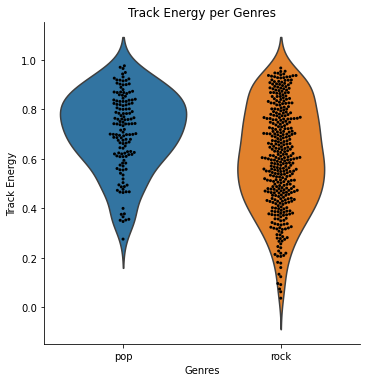

In [14]:
g = sns.catplot(x="genres-transformed", y="track energy", kind="violin", inner=None, data=df2)
sns.swarmplot(x="genres-transformed", y="track energy", color="k", size=3, data=df2, ax=g.ax)
plt.xlabel('Genres') 
plt.ylabel('Track Energy')
plt.title('Track Energy per Genres')

Text(0.5, 1.0, 'Track Energy per Genres')

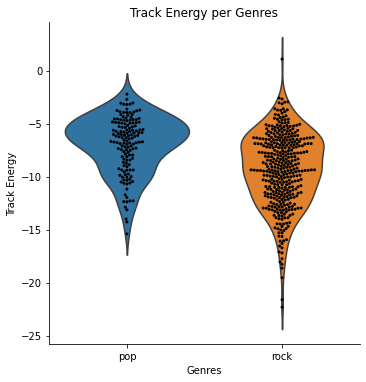

In [15]:
g = sns.catplot(x="genres-transformed", y="track loudness", kind="violin", inner=None, data=df2)
sns.swarmplot(x="genres-transformed", y="track loudness", color="k", size=3, data=df2, ax=g.ax)
plt.xlabel('Genres') 
plt.ylabel('Track Energy')
plt.title('Track Energy per Genres')

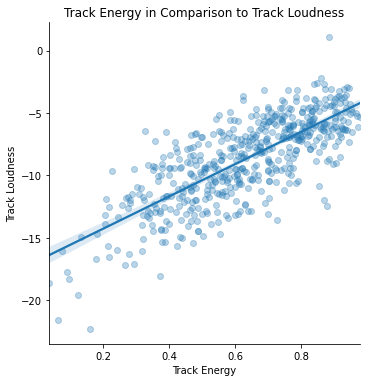

In [16]:
sns.lmplot(x='track energy', y='track loudness', fit_reg=True, data=df2, scatter_kws={'alpha':0.3})
plt.xlabel('Track Energy') 
plt.ylabel('Track Loudness')
plt.title('Track Energy in Comparison to Track Loudness')
plt.show()

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import sklearn as sk

In [18]:
X = df2.loc[:,'track acousticness':'track valence'] #This gets all the columns from Time to Amount
y = df2['genres-transformed']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [19]:
rf = RandomForestClassifier(random_state=1, n_estimators=100)
rf = rf.fit(X_train, y_train)

In [20]:
y_test_pred = rf.predict(X_test) #the predicted values
cm = confusion_matrix(y_test, y_test_pred) #creates a "confusion matrix"
cm

array([[ 16,  24],
       [ 10, 110]])

In [21]:
y_pred = rf.predict(X_test) #the predicted values
conf_matrix = confusion_matrix(y_test, y_pred) #creates a "confusion matrix"
conf_matrix = pd.DataFrame(cm, index=['pop (actual)', 'rock (actual)'], columns = ['pop  (predicted)', 'rock (predicted)']) 
conf_matrix

,pop (predicted),rock (predicted)
pop (actual),16,24
rock (actual),10,110


In [22]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         pop       0.62      0.40      0.48        40
        rock       0.82      0.92      0.87       120

    accuracy                           0.79       160
   macro avg       0.72      0.66      0.68       160
weighted avg       0.77      0.79      0.77       160

